<h1>Process Data</h1>
<h4>Haley Johnson</h4>

<p>Notebook to extract, combine and transform data</p>

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 

<h2>Manipulate Happiness Data</h2>

In [2]:
html = pd.read_html("happiest_cities.html")

In [3]:
happiness_df = html[0]

In [4]:
happiness_df = happiness_df.rename(columns = {'City': 'Location'})

happiness_df['state'] = happiness_df['Location'].apply(lambda s: s.split(",")[-1])
happiness_df['city'] = happiness_df['Location'].apply(lambda s: s.split(",")[0])

happiness_df = happiness_df.drop(columns = ['Location'])

In [5]:
happiness_df['state'] = happiness_df['state'].str.upper()
happiness_df['city'] = happiness_df['city'].str.upper()

<h2>Manipulate Transportation Data</h2>

In [6]:
locations_df = pd.read_csv("EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv")

<h4>Remove Rows Where Location Is Missing</h4>

In [7]:
locations_df = locations_df[pd.isnull(locations_df['CBSA_Name']) == False]

<h4>Adding Percent Columns</h4>

In [8]:
def calc_pct_protect(s):
    '''
    Takes in a row of a dataframe
    Returns the percentage of land
    that is protected'''
    
    total_area = s['Ac_Total']
    unprotected_area = s['Ac_Unpr']
    protected_area = total_area - unprotected_area
    try:
        div = (protected_area / total_area)
    except:
        div = 0
    return div
    

In [9]:
locations_df['PCT_protected'] = locations_df.apply(calc_pct_protect, axis = 1)

locations_df['PCT_water'] = locations_df['Ac_Water'] / locations_df['Ac_Total']
locations_df['pct_D5AR'] = locations_df['D5AR'] / locations_df['CBSA_POP']

<h4>Setting Ranking Columns as Category</h4>

In [10]:
rankings = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked']

for rank in rankings:
    locations_df[rank] = locations_df[rank].astype('category')

<h4>Get City and State Names</h4>

In [11]:
locations_df['CBSA_Name'] = locations_df['CBSA_Name'].astype(str)

In [12]:
locations_df['metro_area_cities'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[0])
locations_df['metro_area_states'] = locations_df['CBSA_Name'].apply(lambda s: str(s).split(",")[-1])

locations_df['city'] = locations_df['metro_area_cities'].apply(lambda s: s.split("-"))
locations_df['state'] = locations_df['metro_area_states'].apply(lambda s: s.split("-"))

In [13]:
locations_df = locations_df.drop(columns = ['metro_area_cities', 'metro_area_states'])

<h3>Explode</h3>

In [14]:
exploded = locations_df.explode('city')
exploded = exploded.explode('state')
exploded = exploded.drop_duplicates()

In [15]:
exploded['city'] = exploded['city'].str.upper()
exploded['state'] = exploded['state'].str.upper()

<h2>Merging Happiness and Transportation Dataframes</h2>

In [16]:
df = exploded.merge(happiness_df, on = ['state', 'city'], how = 'left')

In [17]:
matches = exploded.merge(happiness_df, on = ['state', 'city'])

In [18]:
# NOTE TO SELF: When you add new columns up above, you need to adjust these 
vals = list(matches.columns)[11:-7] + list(happiness_df.columns)[:-2]
df = pd.pivot_table(matches, index = ['city', "state"], values = vals, aggfunc='mean')

In [19]:
df = df.reset_index()

<h2>Data Visualization</h2>

<AxesSubplot:xlabel='Community & Environment', ylabel='pct_D5AR'>

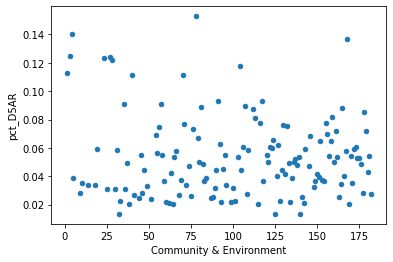

In [20]:
df.plot.scatter(y = 'pct_D5AR', x = 'Community & Environment')

<AxesSubplot:xlabel='Total Score', ylabel='pct_D5AR'>

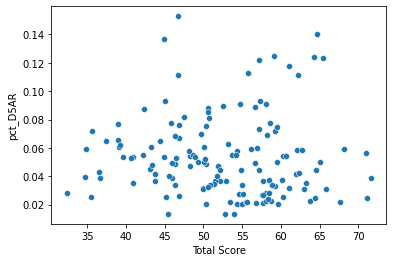

In [21]:
# vaguely linear trend
# cluster not sufficent
sns.scatterplot(y = 'pct_D5AR', x = 'Total Score', data = df)

<h3>Average Happiness Score by Walkability Score Level</h3>

Text(0.5, 0.98, 'Happiness Scores vs Walkability Index Ranking')

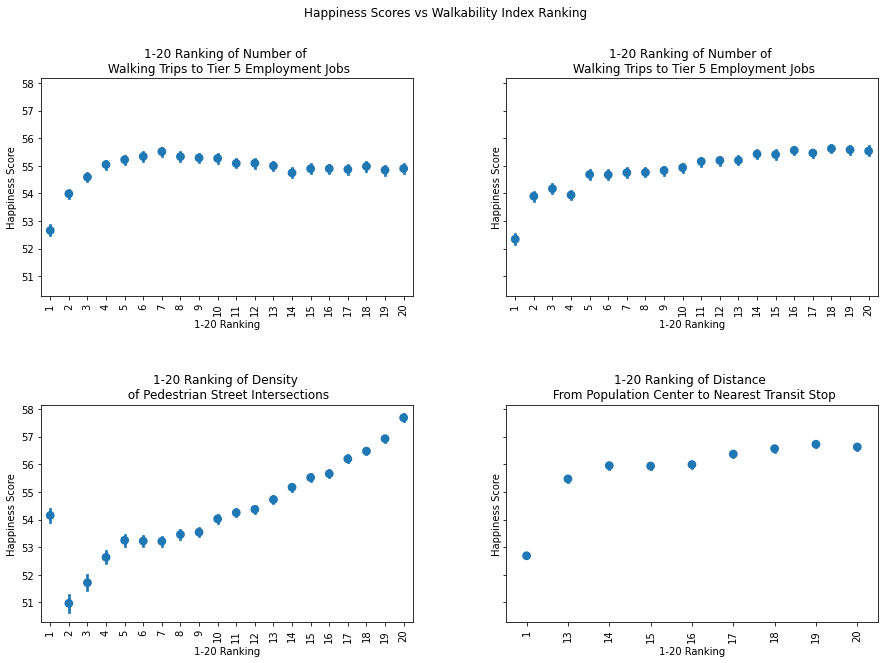

In [61]:
fig, axes = plt.subplots(2, 2, sharey= True)
fig.set_size_inches(15, 10)
fig.subplots_adjust(hspace=0.5, wspace = 0.25)

targets = ['D2A_Ranked', 'D2B_Ranked', 'D3B_Ranked', 'D4A_Ranked']

for i, ax in enumerate(axes.flatten()):
    g = sns.pointplot(x = targets[i], y = 'Total Score', data = matches, join = False, ax = ax)
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    g.set_xlabel(xlabel = '1-20 Ranking')
    g.set_ylabel('Happiness Score')
    
# set titles
axes[0][0].set_title('1-20 Ranking of Number of \n Walking Trips to Tier 5 Employment Jobs')
axes[0][1].set_title('1-20 Ranking of Number of \n Walking Trips to Tier 5 Employment Jobs')
axes[1][0].set_title('1-20 Ranking of Density \n of Pedestrian Street Intersections')
axes[1][1].set_title('1-20 Ranking of Distance \n From Population Center to Nearest Transit Stop')

fig.suptitle("Happiness Scores vs Walkability Index Ranking")

In [ ]:
# g = sns.pointplot(x = 'D2A_Ranked', y = 'Total Score', data = matches, join = False)
# g.set_xticklabels(g.get_xticklabels(),rotation = 90)

<h3>Walkability Scores for Happiest Cities</h3>

<AxesSubplot:xlabel='Pct_AO0', ylabel='Total Score'>

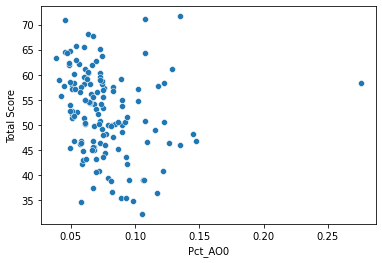

In [31]:
# weak inverse relatioship between not owning a car and happiness
# wealth as a confounding variable?
sns.scatterplot(x = 'Pct_AO0', y = 'Total Score', data = df )

<AxesSubplot:xlabel='PCT_protected', ylabel='Total Score'>

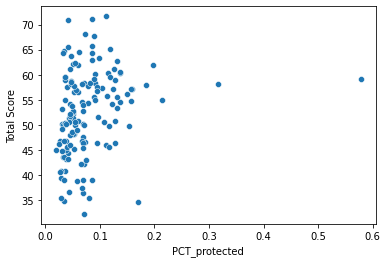

In [32]:
sns.scatterplot(x = 'PCT_protected', y = 'Total Score', data = df)

<AxesSubplot:xlabel='PCT_protected', ylabel='Community & Environment'>

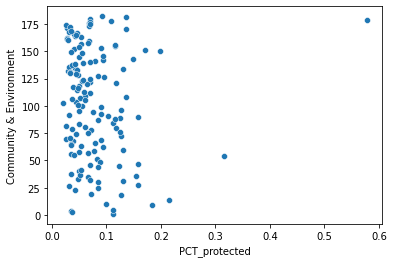

In [33]:
sns.scatterplot(x = 'PCT_protected', y = 'Community & Environment', data = df)

<h4>Association Between Density and Housing</h4>

In [ ]:
# generally positive
# D1A = Residential density
sns.scatterplot(x = 'D1A', y = 'Total Score', data = df)

In [ ]:
sns.barplot(x = df['D1A'], y = df.index, data = df)